In [1]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline

(202, 278)


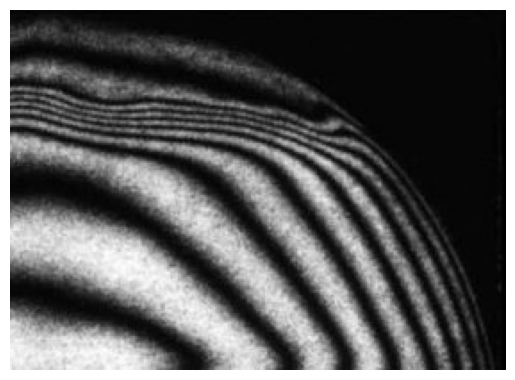

In [2]:
img_path = '1.jpg'

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)

plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [120]:
class Circle:
    
    def __init__(self, i: int, j: int, r: int, M: int) -> None:
        self.c = np.array([i, j])
        self.r = r
        self.M = M

        self.angles = [2*np.pi*i/self.M for i in range(self.M)]
        self.points = []
        self.calc_points_()
        
        self.intencity = []

    def calc_points_(self):
        self.points = [self.c + np.array([self.r*np.cos(alpha), self.r*np.sin(alpha)]).astype(np.int32) for alpha in self.angles]

    def project_intencity(self, img) -> np.ndarray:
        self.intencity = np.array([img[*p] for p in self.points])

        return self.intencity

    def calcA(self) -> float:
        return 0.5*(np.max(self.intencity) - np.min(self.intencity))

    def calcD(self) -> float:
        D = 0.5*np.sum(np.abs(self.intencity[1:]-self.intencity[:-1]))
        return D

    def update_r(self, r):
        self.r = r
        self.calc_points_()
        self.intencity = []

    def draw(self, img):
        img_out = copy.deepcopy(img)

        for p in self.points:
            #print(point, p, img_in[*p], sep=": ")
            if img[*p] < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

        return img_out


In [114]:
def draw_circle(img_in: np.ndarray, c: Circle) -> np.ndarray:
    img_out = copy.deepcopy(img_in)
         
    for p in c.points:
            #print(point, p, img_in[*p], sep=": ")
        try:
            pint = img_in[*p]
        except IndexError:
            pass
        else:
            if pint < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

    return img_out

In [110]:
def draw_circles(img_in: np.ndarray, dx: int, dy: int, r:int, M: int) -> np.ndarray:
    img_out = copy.deepcopy(img_in)
    
    nx = (img_in.shape[0])//dx - 1 
    ny = (img_in.shape[1])//dy - 1

    points = [[x, y] for x in [d*(i+1) for i in range(nx)] for y in [d*(i+1) for i in range(ny)]]
    #print(points)
    #print(*points[1])

    for point in points:
        c = Circle(*point, r, M)
        for p in c.points:
            #print(point, p, img_in[*p], sep=": ")
            if img_in[*p] < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

    return img_out
    

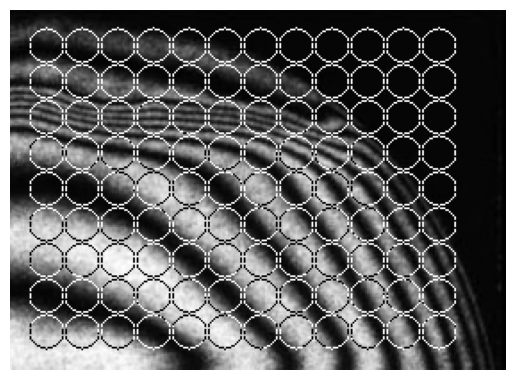

In [107]:
img_c = draw_circles(img, 20,10,50)

plt.imshow(img_c, cmap ='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [127]:
x_max, y_max = *img.shape
alpha = np.pi/4

img_new = []
for x0 in range(x_max):
    img_new_line = []
    for x in range(x0, x_max):
        y = int((x - x0)/np.sin(alpha))
        if y <= y_max:
            new_img_line.append(img[x,y])
    img_new.append(img_new_line)

In [9]:
def get_line(img, alpha, x0) -> tuple:
    line = []
    points = []
    
    x_max = img.shape[0]-1
    y_max = img.shape[1]-1

    y = 0
    x = x0
    while y <= y_max and x <= x_max:
        y = int((x - x0)/np.tan(alpha))
        if y <= y_max:
            points.append([x,y])
            line.append(img[x,y])
        x = x + 1

    return line, points

In [10]:
alpha = np.pi/4
x0 = 0

line, points = get_line(img, alpha, x0)

In [12]:
def draw_points(img, points) -> np.ndarray:
    img_out = copy.deepcopy(img)

    for point in points:
        try:
            img_p = img[*point]
        except IndexError:
            pass
        else:
            img_out[*point] = 0 if img_p > 120 else 255

    return img_out

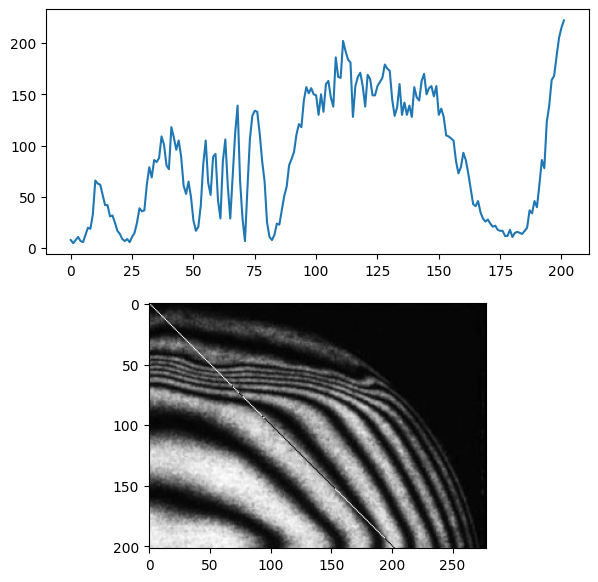

In [20]:
img_line = draw_points(img, points)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(line)

ax2.imshow(img_line, cmap='gray', vmin=0, vmax=255)
plt.show()

In [89]:
def g_linear(K:int) -> list:
    if K%2 == 0:
        g_first = [i for i in range(K//2)]
        a = K/2/sum(g_first)
        g_first = [a*i for i in g_first]

        g = g_first + g_first[::-1]

    else:
        g_first = [i for i in range(K//2 + 1)]
        g = g_first + g_first[K//2-1::-1]
        a = K/sum(g)

        g = [a*i for i in g]
        
    return g

def hist(points: list[int]) -> list:
    hist = [0]*255

    p_len = len(points)
    
    g_funk = g_linear(p_len)
    for p, g in zip(points, g_funk):
        hist[p] += g

    return hist

def average_hist(points: list) -> float:
    histogramm = hist(points)
    hist_range = [i for i in range(255)]
    p_len = len(points)

    avr_cp = sum([i*h for i, h in zip(hist_range, histogramm)])/p_len
    return avr_cp

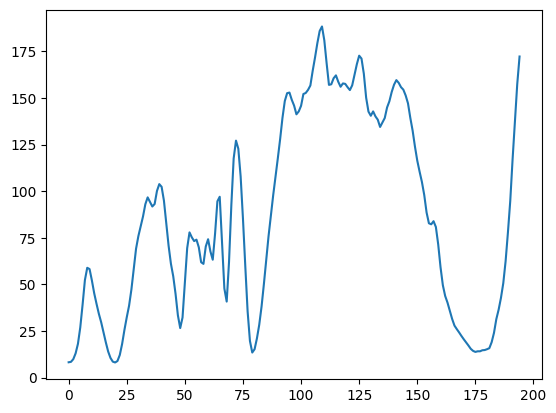

In [90]:
L = 7
seq_len = len(line)
new_line = []
for i in range(seq_len-L):
    points = line[i:i+L]
    p_new = average_hist(points)
    
    new_line.append(p_new)

plt.plot(new_line)
    